In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('ggplot')

In [3]:
def freq_grouped_values(M: np.array, n_intervals: int) -> pd.DataFrame:
    """
    Таблица частот группированной выборки
    """
    df = pd.DataFrame(M)
    start = round(min(M))
    w = max(M)-min(M)
    b = round(w/n_intervals)
    end = round(max(M))
    L = len(M)
    df = df.groupby(pd.cut(M, np.arange(start,end+b,b))).agg(['count'])
    df.columns = df.columns.get_level_values(0)
    df.columns = ['Freq']
    mid_points = np.arange(start+b/2,end+b/2,b)
    df['Mid_points'] = mid_points
    df['Cum_freq'] = df['Freq'].cumsum()
    df['Rel_freq'] = df['Freq'] / L
    df['Rel_c_freq'] = df['Cum_freq'] / L
    df = df[['Mid_points','Freq','Cum_freq','Rel_freq','Rel_c_freq']]
    return df.round(4)

#### Олды на месте?
Сгенерируем данные. Возраст от 0 до 100. Если возраст больше или равен 25 - человек однозначно олд.
Задача - разбить возраст на интервалы, обучить сеть, которя обнаруживает олдов.

In [4]:
age = np.random.randint(0,100,1000)

<AxesSubplot:ylabel='Count'>

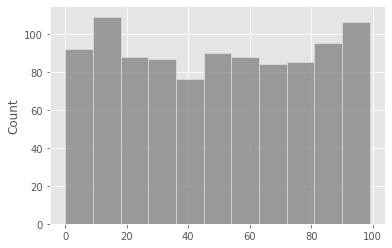

In [5]:
sns.histplot(age, color='grey')

In [6]:
df = pd.DataFrame({"Age": age})

In [7]:
df['IsOld'] = df.Age.apply(lambda x: x>=25) 

In [8]:
df.head(5)

,Age,IsOld
0,47,True
1,92,True
2,41,True
3,80,True
4,6,False


In [9]:
ds = tf.data.Dataset.from_tensor_slices(({"Age": df.Age}, df.IsOld))
ds = ds.batch(8)

In [10]:
# На сколько интервалов разбить выборку
n_intervals = 7
# Размах
w = df.Age.max() - df.Age.min()
# длина интервала
b = round(w/n_intervals)
start = round(min(df.Age))
end = round(max(df.Age))

In [11]:
T = freq_grouped_values(df.Age,n_intervals)

In [12]:
T

,Mid_points,Freq,Cum_freq,Rel_freq,Rel_c_freq
Age,,,,,
"(0, 14]",7.0,151,151,0.151,0.151
"(14, 28]",21.0,151,302,0.151,0.302
"(28, 42]",35.0,125,427,0.125,0.427
"(42, 56]",49.0,132,559,0.132,0.559
"(56, 70]",63.0,138,697,0.138,0.697
"(70, 84]",77.0,145,842,0.145,0.842
"(84, 98]",91.0,143,985,0.143,0.985
"(98, 112]",105.0,6,991,0.006,0.991


Text(0.5, 1.0, 'Гистограмма частот')

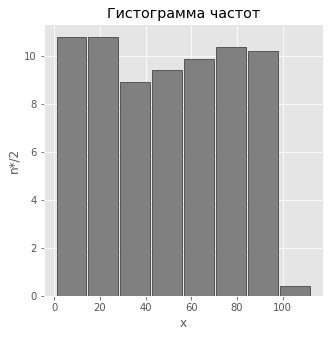

In [13]:
fig, axes = plt.subplots(1, figsize=(5,5))
x = np.arange(start+b,end+b,b)
axes.bar(x=x, height=T.Freq/b, width=-13, color='grey', edgecolor='black',align='edge')
axes.grid(True)
axes.set_xlabel("x")
axes.set_ylabel("n*/2")
axes.set_title("Гистограмма частот")

In [14]:
boundaries = [bnd.right for bnd in T.index]
boundaries

[14, 28, 42, 56, 70, 84, 98, 112]

In [15]:
# В tf boundaries работают по противоположному принципу - левое значение включено в интервал, правое нет
# Поэтому, в отличие от таблицы, интервалы будут равны [0;14), [14;28). Но в целом это не страшно

In [16]:
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=boundaries)

In [17]:
for X, y in ds.take(1):
    print(X)

{'Age': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([47, 92, 41, 80,  6, 33, 76, 75])>}


In [18]:
example = next(iter(ds))[0]

In [19]:
example

{'Age': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([47, 92, 41, 80,  6, 33, 76, 75])>}

In [20]:
feature_layer = layers.DenseFeatures(age_buckets)

In [21]:
feature_layer(example)

<tf.Tensor: shape=(8, 9), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

#### Посмотрели, как все работает. Разобьем выборку на train/test, обучим сеть

In [22]:
train, test = train_test_split(df,train_size=0.7,shuffle=True)

In [23]:
train.head()

,Age,IsOld
713,96,True
892,72,True
69,86,True
928,14,False
454,17,False


In [24]:
train_ds = tf.data.Dataset.from_tensor_slices(({"Age": train.Age}, train.IsOld))
train_ds = train_ds.batch(8)
test_ds = tf.data.Dataset.from_tensor_slices(({"Age": test.Age}, test.IsOld))
test_ds = test_ds.batch(1)

In [25]:
# Это даже не сеть, а один нейрон. Но больше не надо и даже вредно

In [26]:
inputs = {}
inputs["Age"] = tf.keras.Input(shape=(1), name="input")
x = feature_layer(inputs)
out = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=out)

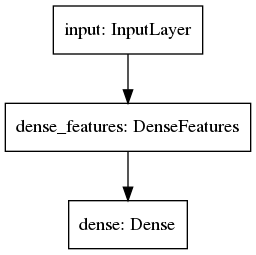

In [27]:
tf.keras.utils.plot_model(model)

In [28]:
model.compile(
    loss=tf.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=tf.keras.metrics.BinaryAccuracy())

In [29]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=25)

Epoch 1/25
88/88 [==============================] - 0s 4ms/step - loss: 2.7093 - binary_accuracy: 0.6229 - val_loss: 2.0441 - val_binary_accuracy: 0.7500
Epoch 2/25
88/88 [==============================] - 0s 3ms/step - loss: 2.1436 - binary_accuracy: 0.7729 - val_loss: 1.9458 - val_binary_accuracy: 0.8500
Epoch 3/25
88/88 [==============================] - 0s 3ms/step - loss: 2.0855 - binary_accuracy: 0.8514 - val_loss: 1.9044 - val_binary_accuracy: 0.8500
Epoch 4/25
88/88 [==============================] - 0s 3ms/step - loss: 2.0557 - binary_accuracy: 0.8514 - val_loss: 1.8840 - val_binary_accuracy: 0.8500
Epoch 5/25
88/88 [==============================] - 0s 3ms/step - loss: 2.0444 - binary_accuracy: 0.8514 - val_loss: 1.8830 - val_binary_accuracy: 0.8500
Epoch 6/25
88/88 [==============================] - 0s 3ms/step - loss: 2.0425 - binary_accuracy: 0.8514 - val_loss: 1.8831 - val_binary_accuracy: 0.8500
Epoch 7/25
88/88 [==============================] - 0s 3ms/step - loss: 2.04

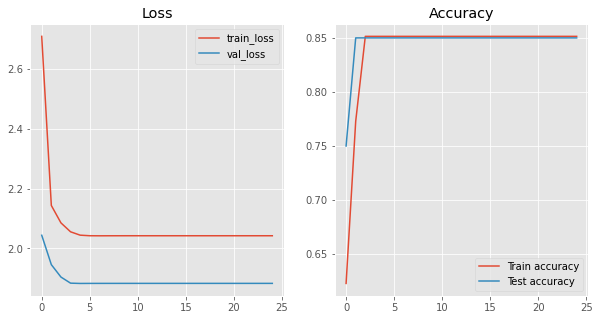

In [30]:
rows, cols = 1, 2
fig, axs = plt.subplots(rows, cols, figsize=(10,5))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Loss')
axs[0].legend(['train_loss','val_loss'])

axs[1].plot(history.history['binary_accuracy'])
axs[1].plot(history.history['val_binary_accuracy'])
axs[1].set_title('Accuracy')
axs[1].legend(['Train accuracy','Test accuracy'])

In [31]:
# Важное замечание. BinaryAccuracy по умолчанию имеет порог 0.5. Т.е. результат интерпретируется тоже
# от порога 0.5, а не 0, хотя в результатаых будут отрицательные числа
test_ds = test_ds.batch(1)
for X, y in test_ds:
    age = X['Age'].numpy().squeeze()
    res = model(X).numpy().squeeze()
    print(f"Age: {age}. Is old: {res > 0.5}")

Age: 89. Is old: True
Age: 79. Is old: True
Age: 20. Is old: False
Age: 14. Is old: False
Age: 12. Is old: False
Age: 34. Is old: False
Age: 17. Is old: False
Age: 31. Is old: False
Age: 22. Is old: False
Age: 76. Is old: True
Age: 98. Is old: True
Age: 17. Is old: False
Age: 7. Is old: False
Age: 58. Is old: True
Age: 56. Is old: True
Age: 88. Is old: True
Age: 72. Is old: True
Age: 3. Is old: False
Age: 13. Is old: False
Age: 60. Is old: True
Age: 24. Is old: False
Age: 57. Is old: True
Age: 13. Is old: False
Age: 99. Is old: True
Age: 82. Is old: True
Age: 26. Is old: False
Age: 43. Is old: True
Age: 80. Is old: True
Age: 44. Is old: True
Age: 93. Is old: True
Age: 50. Is old: True
Age: 6. Is old: False
Age: 30. Is old: False
Age: 31. Is old: False
Age: 69. Is old: True
Age: 95. Is old: True
Age: 84. Is old: True
Age: 22. Is old: False
Age: 40. Is old: False
Age: 45. Is old: True
Age: 58. Is old: True
Age: 81. Is old: True
Age: 35. Is old: False
Age: 45. Is old: True
Age: 19. Is old

In [32]:
# Видим, что классификатор немного завышает. 28 все еще не old. Эффект разбиения.